In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras import layers,Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,concatenate,BatchNormalization,Activation
import os
from sklearn.model_selection import train_test_split

# View Demo Image and Mask

(941, 1193, 3)


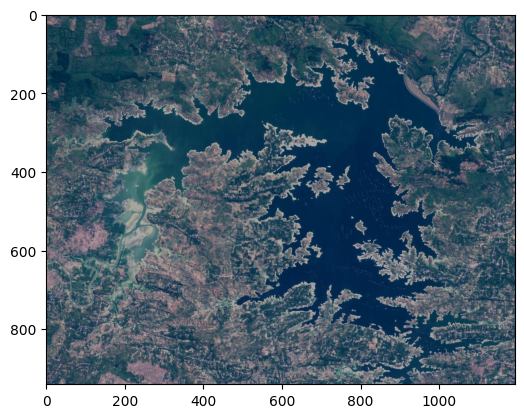

In [ ]:
img=plt.imread("./Merged Dataset/Images/water_body_9.jpg")
plt.imshow(img)
print(img.shape)

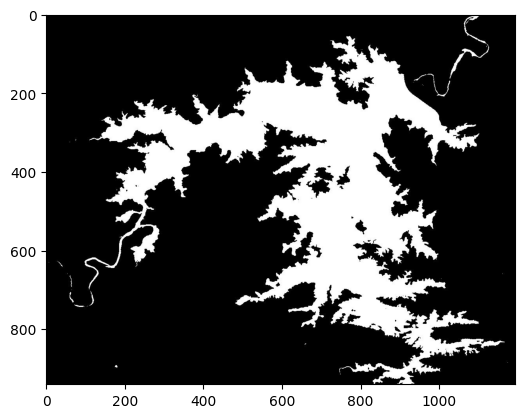

In [ ]:
img=plt.imread("./Merged Dataset/Masks/water_body_9.jpg")
plt.imshow(img)

# Load all the Images and Masks from the Dataset

In [ ]:
def load_imgs_images(dirpath,target):
    files=os.listdir(dirpath)
    for file in files:
        img_path=os.path.join(dirpath,file)
        img=cv2.imread(img_path)
        img=cv2.resize(img,(128,128))
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img=img/255.0
        target.append(img)
    print("Done")
def load_imgs_masks(dirpath,target):
    files=os.listdir(dirpath)
    for file in files:
        img_path=os.path.join(dirpath,file)
        img=cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
        img=cv2.resize(img,(128,128))
        img=np.expand_dims(img, axis=-1)
        #img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img=img/255.0
        target.append(img)
    print("Done")

In [ ]:
images=[]
load_imgs_images("./Merged Dataset/Images",images)

Done


In [ ]:
masks=[]
load_imgs_masks("./Merged Dataset/Masks",masks)

Done


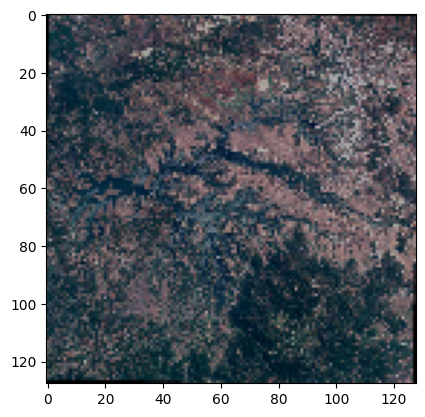

In [ ]:
plt.imshow(images[0])

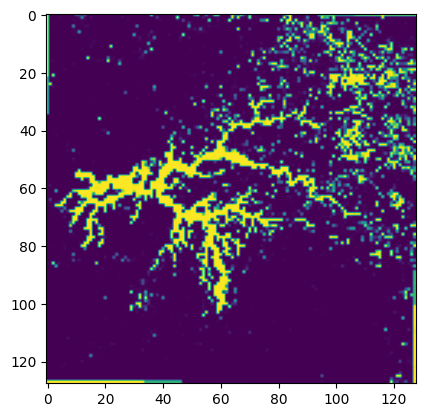

In [ ]:
plt.imshow(masks[0])

# Split Data into Test(75%) and Train(25%) data with maximum data shuffling

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(np.array(images),np.array(masks),test_size=0.25,random_state=42)

# Define UNet Model

## Define Encoder

In [ ]:
def unet_conv(input,filters):
    x=tf.keras.Sequential([
        Conv2D(filters,3,padding="same"),
        BatchNormalization(),
        Activation("relu"),
        Conv2D(filters,3,padding="same"),
        BatchNormalization(),
        Activation("relu")
    ])(input)
    return x

## Define Model

In [ ]:
def unet_plus_plus_model(input_shape=(128, 128, 3), deep_supervision=True):
    inputs = tf.keras.layers.Input(shape=input_shape)

    x_00 = unet_conv(inputs, 64)
    x_10 = unet_conv(MaxPooling2D()(x_00), 128)
    x_20 = unet_conv(MaxPooling2D()(x_10), 256)
    x_30 = unet_conv(MaxPooling2D()(x_20), 512)
    x_40 = unet_conv(MaxPooling2D()(x_30), 1024)

    x_01 = unet_conv(concatenate([x_00, UpSampling2D()(x_10)]), 64)
    x_11 = unet_conv(concatenate([x_10, UpSampling2D()(x_20)]), 128)
    x_21 = unet_conv(concatenate([x_20, UpSampling2D()(x_30)]), 256)
    x_31 = unet_conv(concatenate([x_30, UpSampling2D()(x_40)]), 512)

    x_02 = unet_conv(concatenate([x_00, x_01,UpSampling2D()(x_11)]), 64)
    x_12 = unet_conv(concatenate([x_10, x_11, UpSampling2D()(x_21)]), 128)
    x_22 = unet_conv(concatenate([x_20, x_21, UpSampling2D()(x_31)]), 256)

    x_03 = unet_conv(concatenate([x_00, x_01, x_02, UpSampling2D()(x_12)]), 64)
    x_13 = unet_conv(concatenate([x_10, x_11, x_12, UpSampling2D()(x_22)]), 128)

    x_04 = unet_conv(concatenate([x_00, x_01, x_02, x_03,UpSampling2D()(x_13)]), 64)
    if deep_supervision:
        outputs = [
        tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(x_01),
        tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(x_02),
        tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(x_03),
        tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(x_04)
    ]
        outputs = tf.keras.layers.Average()(outputs)
    else:
        outputs = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(x_04)

    model = Model(inputs=inputs, outputs=outputs, name='Unet_plus_plus')

    return model

## Compile Model

In [ ]:
model = unet_plus_plus_model(input_shape=(128, 128, 3), deep_supervision=True)

In [ ]:
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

# Train Model

In [ ]:
from keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)


history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    batch_size=8,
    callbacks=[early_stopping] )

Epoch 1/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 3593s 13s/step - accuracy: 0.6327 - loss: 0.5020 - val_accuracy: 0.4807 - val_loss: 0.6612
Epoch 2/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 4050s 15s/step - accuracy: 0.6860 - loss: 0.4104 - val_accuracy: 0.5561 - val_loss: 0.6932
Epoch 3/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 4048s 15s/step - accuracy: 0.6958 - loss: 0.3976 - val_accuracy: 0.4425 - val_loss: 0.8174
Epoch 4/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 4085s 15s/step - accuracy: 0.6977 - loss: 0.3937 - val_accuracy: 0.7009 - val_loss: 0.4315
Epoch 5/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 4060s 15s/step - accuracy: 0.7031 - loss: 0.3690 - val_accuracy: 0.7150 - val_loss: 0.3647
Epoch 6/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 4086s 15s/step - accuracy: 0.7122 - loss: 0.3603 - val_accuracy: 0.6413 - val_loss: 0.5545
Epoch 7/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 4031s 15s/step - accuracy: 0.7022 - loss: 0.3805 - val_accuracy: 0.7115 - val_loss: 0.3632
Epoch 8/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 4057s 15s/step - accuracy: 0.7184 -

# Save Model

In [ ]:
import pickle
model.save("unet++.keras")
with open('unet++_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

# Plot graph

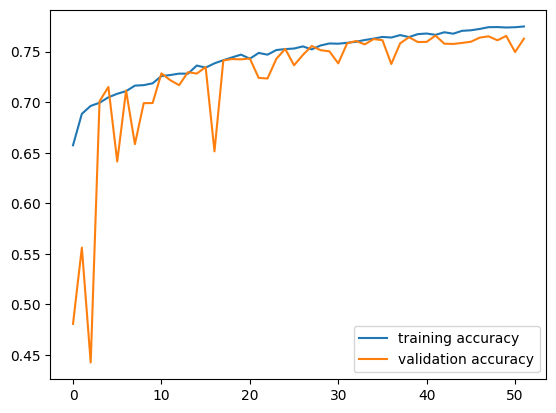

In [ ]:
plt.plot(history.history["accuracy"],label="training accuracy")
plt.plot(history.history["val_accuracy"],label="validation accuracy")
plt.legend()
plt.show()

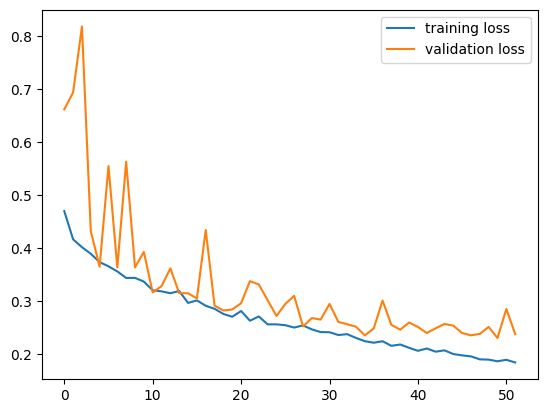

In [ ]:
plt.plot(history.history["loss"],label="training loss")
plt.plot(history.history["val_loss"],label="validation loss")
plt.legend()
plt.show()

# Evaluate Model

In [ ]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model("unet++.keras")

In [ ]:
evaluate = model.evaluate(x_test, y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.7691 - loss: 0.2377
